In [3]:
import numpy as np
import pandas as pd
from selectinf.Simulation.spline import b_spline
from selectinf.Simulation.spline_instance import gaussian_polynomial_interaction_instance
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
import regreg.api as rr
from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import scipy.stats
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/regreg/atoms/slope.py:16: UserWarning: unable to import isotonic regression from sklearn, using a pure python implementation
  warn('unable to import isotonic regression from sklearn, using a pure python implementation')


In [4]:
## T-test for one interaction
def interaction_t_test_single(X_E, Y, Y_mean, interaction, level=0.9):
    interaction = interaction.reshape(-1, 1)
    X_aug = np.concatenate((X_E, interaction), axis=1)
    n, p_prime = X_aug.shape
    
    S = np.linalg.inv(X_aug.T @ X_aug)
    H = X_aug @ S @ X_aug.T
    e = Y - H @ Y
    sigma_hat = np.sqrt(e.T @ e / (n - p_prime))
    sd = sigma_hat * np.sqrt(S[p_prime-1,p_prime-1])
    
    beta_hat = S @ X_aug.T @ Y
    beta_targets = S @ X_aug.T @ Y_mean
    
    # Normal quantiles
    qt_low = scipy.stats.t.ppf((1 - level) / 2, df=n-p_prime)
    qt_up = scipy.stats.t.ppf(1 - (1 - level) / 2, df=n-p_prime)
    assert np.abs(np.abs(qt_low) - np.abs(qt_up)) < 10e-6

    # Construct confidence intervals
    interval_low = beta_hat[p_prime-1] + qt_low * sd
    interval_up = beta_hat[p_prime-1] + qt_up * sd
    
    target = beta_targets[p_prime-1]
    
    ### Test
    mat = np.array([interval_up, interval_low, target])
    # print("intervals: ", mat)
    
    coverage = (target > interval_low) * (target < interval_up)
    
    return coverage, interval_up - interval_low, (interval_up*interval_low > 0)
    
# T-test for all interaction terms
def interaction_t_tests_all(X_E, Y, Y_mean, n_features, active_vars_flag,
                            interactions, selection_idx = None,
                            level=0.9, mode = "allpairs"):
    coverage_list = []
    length_list = []
    selected_interactions = []
    
    if mode == "allpairs":
        for i in range(n_features):
            for j in range(i+1, n_features):
                if selection_idx is not None:
                    interaction_ij = interactions[(i,j)][~selection_idx]
                else:
                    interaction_ij = interactions[(i,j)]
                coverage, length, selected = interaction_t_test_single(X_E, Y, Y_mean, 
                                                             interaction_ij,
                                                             level=level)
                coverage_list.append(coverage)
                length_list.append(length)
                if selected:
                    selected_interactions.append((i,j))
    elif mode == 'weakhierarchy':
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] or active_vars_flag[j]:
                    if selection_idx is not None:
                        interaction_ij = interactions[(i,j)][~selection_idx]
                    else:
                        interaction_ij = interactions[(i,j)]
                    coverage, length, selected = interaction_t_test_single(X_E, Y, Y_mean, 
                                                                 interaction_ij,
                                                                 level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))    
    elif mode == 'stronghierarchy':
        for i in range(n_features):
            for j in range(i+1, n_features):
                if active_vars_flag[i] and active_vars_flag[j]:
                    #print(i,j)
                    if selection_idx is not None:
                        interaction_ij = interactions[(i,j)][~selection_idx]
                    else:
                        interaction_ij = interactions[(i,j)]
                    coverage, length, selected = interaction_t_test_single(X_E, Y, Y_mean, 
                                                                 interaction_ij,
                                                                 level=level)
                    coverage_list.append(coverage)
                    length_list.append(length)
                    if selected:
                        selected_interactions.append((i,j))
    
    return np.array(coverage_list), np.array(length_list), selected_interactions

def naive_inference_quad_inter(X, Y, Y_mean, const, 
                               n_features, interactions, intercept=False,
                               weight_frac=1.25, level=0.9, mode="allpairs"):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features, 
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    n, p = X.shape

    ##estimate noise level in data

    sigma_ = np.std(Y)
    if n > p:
        dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
    else:
        dispersion = sigma_ ** 2

    sigma_ = np.sqrt(dispersion)
    
    groups = np.arange(p)
    ##solve group LASSO with group penalty weights = weights
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    # Don't penalize intercept
    if intercept:
        weights[0] = 0

    conv = const(X=X,
                 Y=Y,
                 groups=groups,
                 weights=weights,
                 useJacobian=True,
                 perturb=np.zeros(p),
                 ridge_term=0.)

    signs, _ = conv.fit()
    nonzero = signs != 0

    if nonzero.sum() > 1+intercept:
        # E: nonzero flag
        X_E = X[:, nonzero]
        
        selected_groups = conv.selection_variable['active_groups']
        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.
        
        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        coverages, lengths, selected_interactions\
            = interaction_t_tests_all(X_E, Y, Y_mean, n_features,
                                      active_vars_flag, interactions, 
                                      level=level, mode = mode)
        
        return coverages, lengths, selected_interactions

    return None, None, None

def data_splitting_quad_inter(X, Y, Y_mean, const, 
                                n_features, interactions, intercept=False,
                                weight_frac=1.25, level=0.9,
                                proportion=0.5, mode="allpairs"):
    """
    Naive inference post-selection for interaction filtering
        X: design matrix, with/without intercept, depending on the value of intercept
        Y: response
        Y_mean: True mean of Y given X
        const: LASSO/Group LASSO solver
        n_features: Number of features, 
            p in the case of linear main effects
            |G| in the case of basis expansion
        interactions: Dictionary of interactions, keys are of form (i,j), i>j
    """
    n, p = X.shape
    
    pi_s = proportion
    subset_select = np.zeros(n, np.bool_)
    subset_select[:int(pi_s * n)] = True
    n1 = subset_select.sum()
    n2 = n - n1
    np.random.shuffle(subset_select)
    X_S = X[subset_select, :]
    Y_S = Y[subset_select]
    X_notS = X[~subset_select, :]
    Y_notS = Y[~subset_select]

    ##estimate noise level in data

    sigma_ = np.std(Y_S)
    if n > p:
        dispersion = np.linalg.norm(Y_S - X_S.dot(np.linalg.pinv(X_S).dot(Y_S))) ** 2 / (n1 - p)
    else:
        dispersion = sigma_ ** 2

    sigma_ = np.sqrt(dispersion)
    
    groups = np.arange(p)
    ##solve group LASSO with group penalty weights = weights
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])
    # Don't penalize intercept
    if intercept:
        weights[0] = 0

    conv = const(X=X_S,
                 Y=Y_S,
                 groups=groups,
                 weights=weights,
                 useJacobian=True,
                 perturb=np.zeros(p),
                 ridge_term=0.)

    signs, _ = conv.fit()
    nonzero = signs != 0
    #print("which.nonzero:", np.nonzero(nonzero))

    if nonzero.sum() > 1+intercept:
        #print("sum nonzero:", nonzero.sum())
        # E: nonzero flag
        X_E = X_notS[:, nonzero]
        
        selected_groups = conv.selection_variable['active_groups']
        active_flag = np.zeros(np.unique(groups).shape[0])
        active_flag[selected_groups] = 1.
        
        #print(active_flag)
        
        if intercept:
            active_vars_flag = active_flag[1:]
        else:
            active_vars_flag = active_flag
        
        coverages, lengths, selected_interactions\
            = interaction_t_tests_all(X_E, Y_notS, Y_mean[~subset_select],
                                      n_features, active_vars_flag,
                                      interactions, subset_select, 
                                      level=level, mode = mode)
        
        return coverages, lengths, selected_interactions

    return None, None, None

In [5]:
(design, data_interaction, Y, Y_mean, X,
 active, active_inter_adj, active_inter_list) \
    = gaussian_polynomial_interaction_instance(n=200, p=50, s=5, rho=0., 
                                              SNR = 0.5, interaction_signal=1,
                                              random_signs=False,
                                              scale=True, center=True,
                                              equicorrelated=True,
                                              structure='stronghierarchy',
                                              intercept=True,
                                              s_interaction=5)

noise_sd: 0.3020422971994363


In [6]:
const = group_lasso.gaussian
for i in range(50):
    np.random.seed(i)
    coverages, lengths, selected_interactions\
        = data_splitting_quad_inter(X=design, Y=Y, Y_mean=Y_mean, const=const,
                                     n_features=50, interactions=data_interaction,
                                     weight_frac=0.5, level=0.9,  
                                     mode='stronghierarchy', intercept=True)
    if coverages is not None:
        if len(coverages) == 0:
            print(i)

In [7]:
def calculate_F1_score_interactions(true_set, selected_list):
    selected_set = set(selected_list)
    # print(true_set, selected_set)

    # precision & recall
    if len(selected_set) > 0:
        precision = len(true_set & selected_set) / len(selected_set)
    else:
        precision = 0
    recall = len(true_set & selected_set) / len(true_set)

    if precision + recall > 0:
        return 2 * precision * recall / (precision + recall)
    else:
        return 0

In [8]:
# Convert the matrix into a list of tuples
active_inter_set = set([tuple(row) for row in active_inter_list])
calculate_F1_score_interactions(true_set=active_inter_set,
                                selected_list=selected_interactions)

0

## A Small-scale Simulation for Naive and Data Splitting

In [11]:
coverage_naive_l = []
lengths_naive_l = []
coverage_ds_l = []
lengths_ds_l = []
F1_i_naive_l = []
F1_i_ds_l = []
intercept_flag = True
p=50
weight_const = 0.5

for i in range(50):
    const = group_lasso.gaussian
    
    while True:  # run until we get some selection
        no_selection = False
        
        (design, data_interaction, Y, Y_mean, X,
         active, active_inter_adj, active_inter_list) \
        = gaussian_polynomial_interaction_instance(n=500,
                                                   p=p,
                                                   s=5,
                                                   rho=0.5,
                                                   SNR = 1,
                                                   order=2,
                                                   interaction_signal=1,
                                                   random_signs=False,
                                                   scale=True,
                                                   center=True,
                                                   equicorrelated=True,
                                                   structure='stronghierarchy',
                                                   s_interaction=5,
                                                   intercept=intercept_flag)
        
        coverages, lengths, selected_interactions\
            = naive_inference_quad_inter(X=design, Y=Y, 
                                         intercept=intercept_flag,
                                         Y_mean=Y_mean, const=const,
                                         n_features=p, interactions=data_interaction,
                                         weight_frac=weight_const, level=0.9,  mode='weakhierarchy')
        # Convert the matrix into a list of tuples
        active_inter_set = set([tuple(row) for row in active_inter_list])
        
        if coverages is not None:
            
            coverages_ds, lengths_ds, selected_interactions_ds\
                = data_splitting_quad_inter(X=design, Y=Y, Y_mean=Y_mean, 
                                            intercept=intercept_flag,
                                            const=const, n_features=p, 
                                            interactions=data_interaction,
                                            weight_frac=weight_const, level=0.9,  
                                            mode='weakhierarchy')
            
            if coverages_ds is not None:
                if np.isnan(np.mean(coverages_ds)):
                    print(coverages_ds)
                #print(lengths_ds is None)
                #print(selected_interactions_ds is None)
                
                F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                             selected_list=selected_interactions)
                F1_i_ds = calculate_F1_score_interactions(true_set=active_inter_set,
                  selected_list=selected_interactions_ds)
                coverage_naive_l.append(np.mean(coverages))
                lengths_naive_l.append(np.mean(lengths))
                coverage_ds_l.append(np.mean(coverages_ds))
                lengths_ds_l.append(np.mean(lengths_ds))
                F1_i_naive_l.append(F1_i)
                F1_i_ds_l.append(F1_i_ds)
                break
       

noise_sd: 0.2650503045974474
noise_sd: 0.28247823622463647
noise_sd: 0.29543763923054756
noise_sd: 0.2921654278982319
noise_sd: 0.2689829237577537
noise_sd: 0.29519438032060796
noise_sd: 0.2915511926809464


KeyboardInterrupt: 

In [10]:
print(np.mean(np.array(coverage_naive_l)))
print(np.mean(np.array(coverage_ds_l)))
print(np.mean(np.array(lengths_naive_l)))
print(np.mean(np.array(lengths_ds_l)))
print(np.mean(np.array(F1_i_naive_l)))
print(np.mean(np.array(F1_i_ds_l)))

0.8452727839383112
0.9189637717785999
1.5888382045851563
2.2894007943142642
0.08310298973395006
0.058290990722302406


# Simulation with Varying Sparsity

In [16]:
def interaction_filter_vary_s(nsim=100):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["sparsity size"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    intercept_flag = True

    for s in [5, 10, 20]:  # [0.01, 0.03, 0.06, 0.1]:
        for i in range(nsim):

            inst, const = (gaussian_polynomial_interaction_instance,
                           group_lasso.gaussian)

            while True:  # run until we get some selection
                (design, data_interaction, Y, Y_mean, X,
                 active, active_inter_adj, active_inter_list) \
                                            = inst(n=500,
                                                   p=p,
                                                   s=10,
                                                   rho=0.5,
                                                   SNR = 1,
                                                   order=2,
                                                   interaction_signal=1,
                                                   random_signs=False,
                                                   scale=True,
                                                   center=True,
                                                   equicorrelated=True,
                                                   structure='stronghierarchy',
                                                   s_interaction=s,
                                                   intercept=intercept_flag)

                noselection = False  # flag for a certain method having an empty selected set

                if not noselection:
                    # MLE inference
                    coverages_ds, lengths_ds, selected_interactions_ds\
                        = data_splitting_quad_inter(X=design, Y=Y, Y_mean=Y_mean,
                                            const=const, n_features=50, 
                                            interactions=data_interaction,
                                            weight_frac=0.5, level=0.9,  
                                            mode='weakhierarchy')
                    
                    # Convert the matrix into a list of tuples
                    active_inter_set = set([tuple(row) for row in active_inter_list])
                    F1_i_ds = calculate_F1_score_interactions(true_set=active_inter_set,
                                                selected_list=selected_interactions_ds)
                    noselection = (coverages_ds is None)

                if not noselection:
                    coverages, lengths, selected_interactions\
                        = naive_inference_quad_inter(X=design, Y=Y, 
                                         Y_mean=Y_mean, const=const,
                                         n_features=50, interactions=data_interaction,
                                         weight_frac=0.5, level=0.9,  mode='weakhierarchy')
                    F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                                    selected_list=selected_interactions)
                    noselection = (coverages is None)

                if not noselection:
                    # Naive
                    oper_char["sparsity size"].append(s)
                    oper_char["coverage rate"].append(np.mean(coverages))
                    oper_char["avg length"].append(np.mean(lengths))
                    oper_char["F1 score interaction"].append(F1_i)
                    oper_char["method"].append('Naive')

                    # Data splitting
                    oper_char["sparsity size"].append(s)
                    oper_char["coverage rate"].append(np.mean(coverages_ds))
                    oper_char["avg length"].append(np.mean(lengths_ds))
                    oper_char["F1 score interaction"].append(F1_i_ds)
                    oper_char["method"].append('Data Splitting')

                    break  # Go to next iteration if we have some selection
    return oper_char

In [17]:
oper_char = interaction_filter_vary_s(100)

noise_sd: 0.3884966269757931
noise_sd: 0.411017786751133
noise_sd: 0.38698510693672566
noise_sd: 0.3427753287868247
noise_sd: 0.4082122996429435
noise_sd: 0.3545420451363839
noise_sd: 0.4204960006000351
noise_sd: 0.3787070462973604
noise_sd: 0.38030082521185266
noise_sd: 0.3750359667077306
noise_sd: 0.3952553379046471
noise_sd: 0.3827772551058084
noise_sd: 0.4024961892114979
noise_sd: 0.42585083128409257
noise_sd: 0.36780933390603837
noise_sd: 0.4096447660233882
noise_sd: 0.39008183540984487
noise_sd: 0.42179787281212344
noise_sd: 0.3965269877363023
noise_sd: 0.4127106017171633
noise_sd: 0.3463120900791823
noise_sd: 0.3957264981503903
noise_sd: 0.4002829665264238
noise_sd: 0.39743420288236064
noise_sd: 0.40316051217199594
noise_sd: 0.376585212662319
noise_sd: 0.39674193225552024
noise_sd: 0.3912700459214325
noise_sd: 0.3767464420231913
noise_sd: 0.3882762749258405
noise_sd: 0.39581259730477014
noise_sd: 0.3757565455192285
noise_sd: 0.4034137937797981
noise_sd: 0.35543929333972807
noise

In [41]:
def interaction_filter_vary_SNR(nsim=100):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["SNR"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []

    for SNR in [0.5, 1, 5, 10]:  # [0.01, 0.03, 0.06, 0.1]:
        for i in range(nsim):

            inst, const = (gaussian_polynomial_interaction_instance,
                           group_lasso.gaussian)

            while True:  # run until we get some selection
                (design, data_interaction, Y, Y_mean, X,
                 active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p=50, s=10, rho=0, SNR = SNR,
                           interaction_signal=1, random_signs=False,
                           scale=True, center=False, equicorrelated=True,
                           structure='stronghierarchy', s_interaction=10)

                noselection = False  # flag for a certain method having an empty selected set

                if not noselection:
                    # MLE inference
                    coverages_ds, lengths_ds, selected_interactions_ds\
                        = data_splitting_quad_inter(X=design, Y=Y, Y_mean=Y_mean,
                                            const=const, n_features=50, 
                                            interactions=data_interaction,
                                            weight_frac=0.5, level=0.9,  
                                            mode='weakhierarchy')
                    
                    # Convert the matrix into a list of tuples
                    active_inter_set = set([tuple(row) for row in active_inter_list])
                    F1_i_ds = calculate_F1_score_interactions(true_set=active_inter_set,
                                                selected_list=selected_interactions_ds)
                    noselection = (coverages_ds is None)

                if not noselection:
                    coverages, lengths, selected_interactions\
                        = naive_inference_quad_inter(X=design, Y=Y, 
                                         Y_mean=Y_mean, const=const,
                                         n_features=50, interactions=data_interaction,
                                         weight_frac=0.5, level=0.9,  mode='weakhierarchy')
                    F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                                    selected_list=selected_interactions)
                    noselection = (coverages is None)

                if not noselection:
                    # Naive
                    oper_char["SNR"].append(SNR)
                    oper_char["coverage rate"].append(np.mean(coverages))
                    oper_char["avg length"].append(np.mean(lengths))
                    oper_char["F1 score interaction"].append(F1_i)
                    oper_char["method"].append('Naive')

                    # Data splitting
                    oper_char["SNR"].append(SNR)
                    oper_char["coverage rate"].append(np.mean(coverages_ds))
                    oper_char["avg length"].append(np.mean(lengths_ds))
                    oper_char["F1 score interaction"].append(F1_i_ds)
                    oper_char["method"].append('Data Splitting')

                    break  # Go to next iteration if we have some selection
    return oper_char

In [42]:
oper_char_SNR = interaction_filter_vary_SNR(100)

noise_sd: 2.5289918207180486
noise_sd: 2.5416380693825307
noise_sd: 2.502627406500596
noise_sd: 2.550552438710339
noise_sd: 2.487206030816423
noise_sd: 2.4851622202793346
noise_sd: 2.5241629167162376
noise_sd: 2.5610541126990864
noise_sd: 2.5303544795387802
noise_sd: 2.4650800157769632
noise_sd: 2.52345321852021
noise_sd: 2.4843752733819686
noise_sd: 2.5387724246339336
noise_sd: 2.5081061755648335
noise_sd: 2.483553727007363
noise_sd: 2.49900391765185
noise_sd: 2.533156639126128
noise_sd: 2.485321235873349
noise_sd: 2.4810328271139483
noise_sd: 2.5233891174155514
noise_sd: 2.5094114534615506
noise_sd: 2.481989277905682
noise_sd: 2.49401119520862
noise_sd: 2.4597564285811475
noise_sd: 2.479579950401764
noise_sd: 2.4998897735301053
noise_sd: 2.5260461949563413
noise_sd: 2.5604436351336557
noise_sd: 2.5283583898022006
noise_sd: 2.592778465914668
noise_sd: 2.4800768185602555
noise_sd: 2.492244586085796
noise_sd: 2.5464126516818473
noise_sd: 2.4534683431156337
noise_sd: 2.530172848428699
no

In [50]:
def plotting(oper_char_df, x_axis='p', hue='method'):
    #sns.histplot(oper_char_df["sparsity size"])
    #plt.show()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(10,10))

    #print("Mean coverage rate/length:")
    #print(oper_char_df.groupby([x_axis, hue]).mean())
    my_palette = {"Proposed": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    cov_plot = sns.boxplot(y=oper_char_df["coverage rate"],
                           x=oper_char_df[x_axis],
                           hue=oper_char_df[hue],
                           palette=my_palette,
                           orient="v", ax=ax1,
                           showmeans=True,
                           linewidth=1)
    cov_plot.set(title='Coverage')
    cov_plot.set_ylim(0., 1.05)
    #plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    #ax1.set_ylabel("")  # remove y label, but keep ticks
    ax1.set_xlabel(x_axis)

    len_plot = sns.boxplot(y=oper_char_df["avg length"],
                           x=oper_char_df[x_axis],
                           hue=oper_char_df[hue],
                           palette=my_palette,
                           orient="v", ax=ax2,
                           linewidth=1)
    len_plot.set(title='Length')
    # len_plot.set_ylim(0, 100)
    # len_plot.set_ylim(3.5, 7.8)
    # plt.tight_layout()
    # ax2.set_ylabel("")  # remove y label, but keep ticks
    ax2.set_xlabel(x_axis)

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles, labels, loc='lower center', ncol=4)
    

    F1_plot = sns.boxplot(y=oper_char_df["F1 score interaction"],
                          x=oper_char_df[x_axis],
                          hue=oper_char_df[hue],
                          palette=my_palette,
                          orient="v", ax=ax3,
                          linewidth=1)
    F1_plot.set(title='F1 score')
    ax3.set_xlabel(x_axis)

    size_plot = sns.boxplot(y=oper_char_df["|G|"],
                          x=oper_char_df[x_axis],
                          hue=oper_char_df[hue],
                          palette=my_palette,
                          orient="v", ax=ax4,
                          linewidth=1)
    size_plot.set(title='|G|')
    ax4.set_xlabel(x_axis)

    cov_plot.legend_.remove()
    len_plot.legend_.remove()
    F1_plot.legend_.remove()
    size_plot.legend_.remove()

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    plt.show()
    
    
def plotting_instance(instance_df, x_axis='p',
                      distance_lims=None,
                      colinearity_lims=None):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,6))


    dist_plot = sns.boxplot(y=instance_df["distance"],
                           x=instance_df[x_axis],
                           orient="v", ax=ax1,
                           showmeans=True,
                           linewidth=1)
    dist_plot.set(title='Distance')
    ax1.set_xlabel(x_axis)
    if distance_lims is not None:
        dist_plot.set_ylim(distance_lims[0], distance_lims[1])

    colin_plot = sns.boxplot(y=instance_df["colinearity"],
                           x=instance_df[x_axis],
                           orient="v", ax=ax2,
                           linewidth=1)
    colin_plot.set(title='Colinearity')
    ax2.set_xlabel(x_axis)
    if colinearity_lims is not None:
        colin_plot.set_ylim(colinearity_lims[0], colinearity_lims[1])

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.2)

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    plt.show()

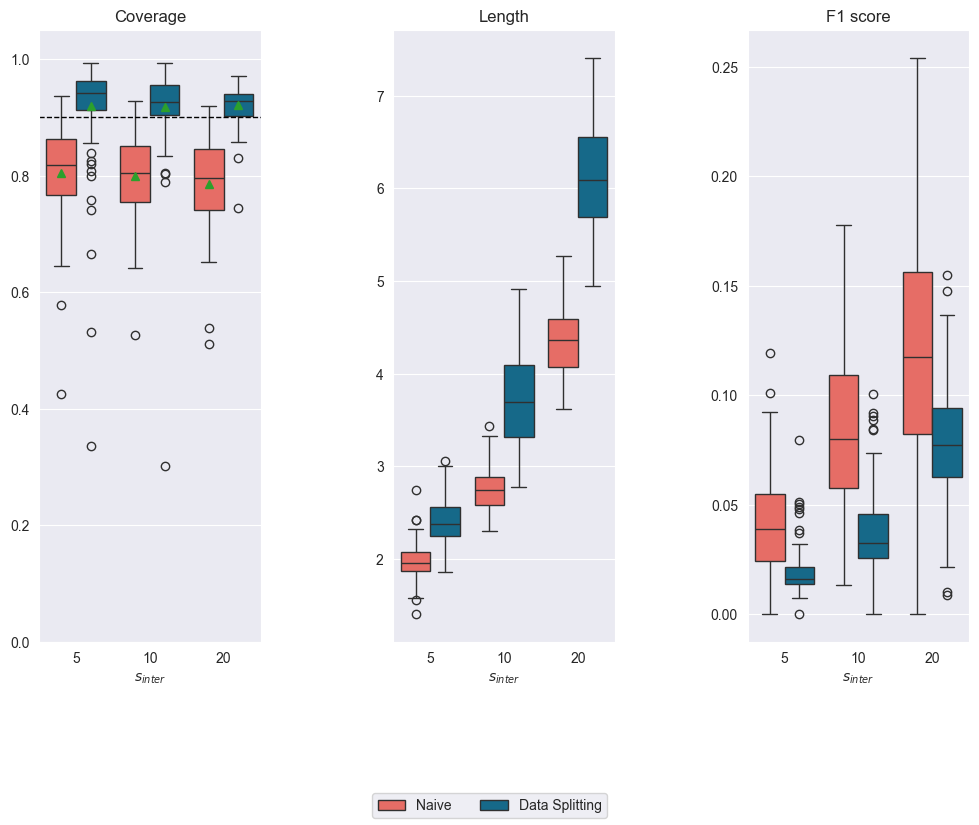

In [19]:
plotting(x_axis="sparsity size", oper_char_df=oper_char)

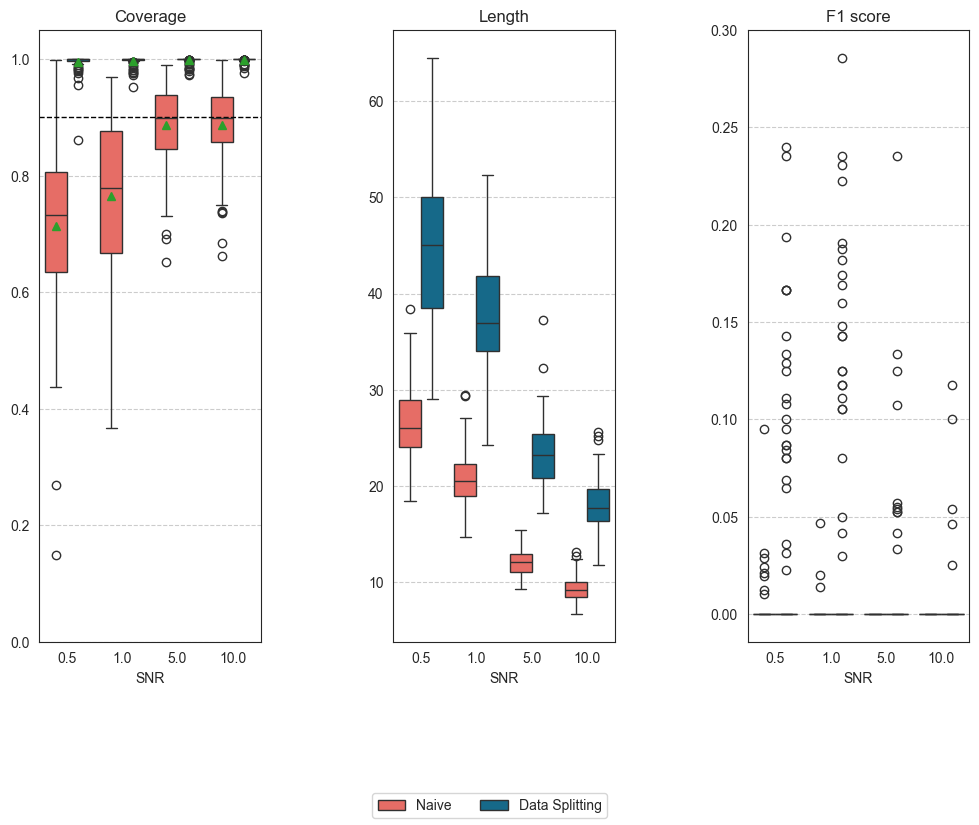

In [46]:
plotting(x_axis="SNR", oper_char_df=oper_char_SNR)

# Plotting Closeness of Main Effect Spaces and Interaction Spaces

In [22]:
def proj_mat(X):
    return X @ np.linalg.inv(X.T @ X) @ X.T

def proj_coef(X, Y):
    return np.linalg.inv(X.T @ X) @ X.T @ Y

In [52]:
def interaction_filter_vary_rho(nsim=100):
    """
    Compare to R randomized lasso
    """

    # Operating characteristics
    oper_char = {}
    oper_char["rho"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score interaction"] = []
    oper_char["|G|"] = []
    
    instance_metrics = {}
    instance_metrics["rho"] = []
    instance_metrics["distance"] = []
    instance_metrics["colinearity"] = []

    for rho in [0., 0.2, 0.4, 0.6]:  # [0.01, 0.03, 0.06, 0.1]:
        for i in range(nsim):

            inst, const = (gaussian_polynomial_interaction_instance,
                           group_lasso.gaussian)

            while True:  # run until we get some selection
                (design, data_interaction, Y, Y_mean, X,
                 active, active_inter_adj, active_inter_list) \
                    = inst(n=500, p=50, s=5, rho=rho, SNR = 1, order=2,
                           interaction_signal=1, random_signs=False,
                           scale=True, center=True, equicorrelated=True,
                           intercept=True,
                           structure='stronghierarchy', s_interaction=5)

                noselection = False  # flag for a certain method having an empty selected set

                if not noselection:
                    # DS inference
                    coverages_ds, lengths_ds, selected_interactions_ds\
                        = data_splitting_quad_inter(X=design, Y=Y, Y_mean=Y_mean,
                                            const=const, n_features=50, 
                                            interactions=data_interaction,
                                            weight_frac=0.5, level=0.9, intercept=True,
                                            mode='weakhierarchy')
                    
                    # Convert the matrix into a list of tuples
                    active_inter_set = set([tuple(row) for row in active_inter_list])
                    F1_i_ds = calculate_F1_score_interactions(true_set=active_inter_set,
                                                selected_list=selected_interactions_ds)
                    noselection = (coverages_ds is None)

                if not noselection:
                    coverages, lengths, selected_interactions\
                        = naive_inference_quad_inter(X=design, Y=Y, 
                                         Y_mean=Y_mean, const=const,
                                         n_features=50, interactions=data_interaction,
                                         weight_frac=0.5, level=0.9, intercept=True,mode='weakhierarchy')
                    F1_i = calculate_F1_score_interactions(true_set=active_inter_set,
                                                    selected_list=selected_interactions)
                    noselection = (coverages is None)

                if not noselection:
                    # Naive
                    oper_char["rho"].append(rho)
                    oper_char["coverage rate"].append(np.mean(coverages))
                    oper_char["avg length"].append(np.mean(lengths))
                    oper_char["F1 score interaction"].append(F1_i)
                    oper_char["method"].append('Naive')
                    oper_char["|G|"].append(len(selected_interactions))

                    # Data splitting
                    oper_char["rho"].append(rho)
                    oper_char["coverage rate"].append(np.mean(coverages_ds))
                    oper_char["avg length"].append(np.mean(lengths_ds))
                    oper_char["F1 score interaction"].append(F1_i_ds)
                    oper_char["method"].append('Data Splitting')
                    oper_char["|G|"].append(len(selected_interactions_ds))
                    
                    # Calculating instance metrics
                    interaction_df = pd.DataFrame(data_interaction)
                    main_proj = proj_mat(design)
                    inter_proj = proj_mat(np.array(interaction_df))
                    distance = np.linalg.norm(main_proj - inter_proj)
                    i_to_m = proj_coef(design, np.array(interaction_df))
                    ortho_metric = np.linalg.norm(i_to_m)
                    
                    instance_metrics["rho"].append(rho)
                    instance_metrics["distance"].append(distance)
                    instance_metrics["colinearity"].append(ortho_metric)
                    

                    break  # Go to next iteration if we have some selection
    return oper_char, instance_metrics

In [53]:
oper_char_rho, instance_metrics_rho = interaction_filter_vary_rho(100)

noise_sd: 0.13762505518907195
noise_sd: 0.13984336477801412
noise_sd: 0.13777511462260697
noise_sd: 0.13677028666927626
noise_sd: 0.13473725287351726
noise_sd: 0.14525403762301284
noise_sd: 0.1441115237887218
noise_sd: 0.13109287272512402
noise_sd: 0.14722167353309967
noise_sd: 0.14267877598142487
noise_sd: 0.15062410441275048
noise_sd: 0.1331728232426788
noise_sd: 0.14802334536757142
noise_sd: 0.13569893965977212
noise_sd: 0.14199191389663976
noise_sd: 0.14482170553336293
noise_sd: 0.14781268717843238
noise_sd: 0.13752192588602702
noise_sd: 0.13747105423815512
noise_sd: 0.13786694200302657
noise_sd: 0.14758808672483612
noise_sd: 0.14552397789818822
noise_sd: 0.14951086396043214
noise_sd: 0.13758542130148063
noise_sd: 0.1406256965205922
noise_sd: 0.14599042373785293
noise_sd: 0.14660765143372745
noise_sd: 0.13540943931345437
noise_sd: 0.14606104922494115
noise_sd: 0.13167279008237048
noise_sd: 0.1441216612963038
noise_sd: 0.1342926546201027
noise_sd: 0.1533752670914212
noise_sd: 0.1361

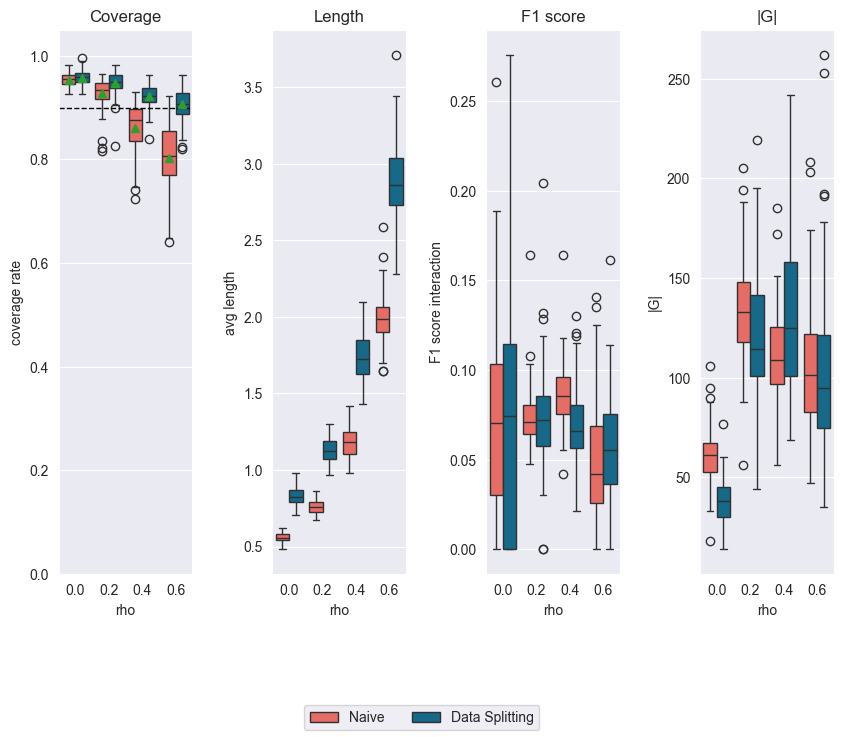

In [54]:
plotting(x_axis="rho", oper_char_df=pd.DataFrame(oper_char_rho))

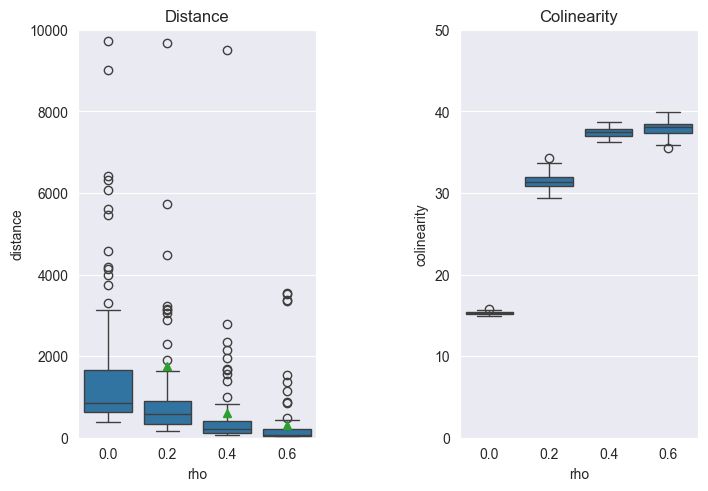

In [49]:
plotting_instance(x_axis="rho", 
                  instance_df=pd.DataFrame(instance_metrics_rho),
                  distance_lims=(0,10000),
                  colinearity_lims=(0,50))